#### This research based project studies the eye landmark data to estimate the ideal range for Eye Aspect Ratio (EAR) and hence contribute to the research paper associated with this project.

Libraries

In [1]:
import cv2
import mediapipe as mp
import numpy as np

import pandas as pd   # For collecting data for research
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import random
%matplotlib inline

Objects

In [2]:
# Drowsiness detection using face landmark detection
mp_sol = mp.solutions
mp_drawing = mp_sol.drawing_utils
mp_drawing_styles = mp_sol.drawing_styles
mp_face_mesh = mp_sol.face_mesh
facemesh = mp_face_mesh.FaceMesh(max_num_faces = 1)
mp_holistic = mp_sol.holistic

landmark_style = mp_drawing.DrawingSpec((0,255,0), thickness=1, circle_radius=1)
connection_style = mp_drawing.DrawingSpec((0,0,255), thickness=1, circle_radius=1)

Data

In [3]:
FACE = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 
        152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103,67, 109]
LIPS = [61, 146, 91, 181, 84, 17, 314, 405, 321, 375,291, 308, 324, 318, 402, 317, 14, 87, 178, 
        88, 95,185, 40, 39, 37,0 ,267 ,269 ,270 ,409, 415, 310, 311, 312, 13, 82, 81, 42, 183, 78]
LOWER_LIPS = [61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95]
UPPER_LIPS = [185, 40, 39, 37,0 ,267 ,269 ,270 ,409, 415, 310, 311, 312, 13, 82, 81, 42, 183, 78] 

# Left eyes indices 
LEFT_EYE = [362, 398, 384, 385, 386, 387, 388, 466, 382, 381, 380, 374, 373, 390, 249, 263]
LEFT_EYEBROW = [336, 296, 334, 293, 300, 276, 283, 282, 295, 285]

# right eyes indices
RIGHT_EYE = [33, 246, 161, 160, 159, 158, 157, 173, 7, 163, 144, 145, 153, 154, 155, 133]  
RIGHT_EYEBROW = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46]

EYES = [362, 398, 384, 385, 386, 387, 388, 466, 382, 381, 380, 374, 373, 390, 249, 263, 
        33, 246, 161, 160, 159, 158, 157, 173, 7, 163, 144, 145, 153, 154, 155, 133] 

Functions

In [4]:
def eu_dist(pt1,pt2):
    x = np.square(pt2[0] - pt1[0])
    y = np.square(pt2[1] - pt1[1])
    z = np.square(pt2[2] - pt1[2])
    dist = np.sqrt(x + y + z)
    return(dist)


def blinked(le_nll, re_nll):
    left_v, right_v, ratio_le, ratio_re = 0, 0, 0, 0
    if len(le_nll) == 0 or len(re_nll) == 0:
        l_val, r_val = 0, 0
    
    else:
        # h for horizontal, v for vertical
        left_h = eu_dist(le_nll[0], le_nll[15])
        right_h = eu_dist(re_nll[0], re_nll[15])
        i = 1
        while i < 8:
            left_v += eu_dist(le_nll[i], le_nll[i + 7])
            right_v += eu_dist(re_nll[i], re_nll[i + 7])
            i += 1

        ratio_le = left_v/(7*left_h)
        ratio_re = right_v/(7*right_h)
        
        if ratio_le > 0.20:    # citation needed in value of EAR
            l_val = 1
        else:
            l_val = 0

        if ratio_re > 0.20:
            r_val = 1
        else:
            r_val = 0
    
    return((ratio_le, ratio_re))
#     return((l_val, r_val))


def aplist(le_nll, re_nll):
    le, re = [],[]
    if len(le_nll) == 0 or len(re_nll) == 0:
        le, re = [], []
    else:
        le.append(le_nll[2])
        le.append(le_nll[14])
        le.append(le_nll[8])
        le.append(le_nll[9])
        le.append(le_nll[10])
        le.append(le_nll[11])
        le.append(le_nll[12])
        le.append(le_nll[15])
        le.append(le_nll[7])
        le.append(le_nll[6])
        le.append(le_nll[5])
        le.append(le_nll[4])
        le.append(le_nll[3])
        le.append(le_nll[13])
        le.append(le_nll[0])
        le.append(le_nll[1])

        re.append(re_nll[1])
        re.append(re_nll[15])
        re.append(re_nll[12])
        re.append(re_nll[11])
        re.append(re_nll[10])
        re.append(re_nll[9])
        re.append(re_nll[8])
        re.append(re_nll[14])
        re.append(re_nll[0])
        re.append(re_nll[13])
        re.append(re_nll[3])
        re.append(re_nll[4])
        re.append(re_nll[5])
        re.append(re_nll[6])
        re.append(re_nll[7])
        re.append(re_nll[2])
    
    return(le, re)

Driver Facial Expression Monitoring and Driver Pose Detection

In [7]:
cap = cv2.VideoCapture("test1.mp4")

frame_no, drowsy = 0, 0
data = []  # for data collection
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():
        frame_no += 1
        success, frame = cap.read()
        frame = cv2.flip(frame, 1)
        ih, iw, ic = frame.shape
        le_nll, re_nll = [], []
        
        if not success:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue
        
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        frame.flags.writeable = False
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Make detection
        results_fm = facemesh.process(frame)
        results_hol = holistic.process(frame)
        
        frame.flags.writeable = True
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        if results_fm.multi_face_landmarks:
            for flms in results_fm.multi_face_landmarks:
                # Eyes and Face Oval
                mp_drawing.draw_landmarks(frame, results_hol.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                                          landmark_drawing_spec = None, connection_drawing_spec = mp_drawing_styles
                                          .get_default_face_mesh_contours_style())
                # Left Hand Landmarks
                mp_drawing.draw_landmarks(frame, results_hol.left_hand_landmarks, mp_sol.hands_connections.HAND_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1),
                                          mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=1, circle_radius=1))
                # Right Hand Landmarks
                mp_drawing.draw_landmarks(frame, results_hol.right_hand_landmarks, mp_sol.hands_connections.HAND_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1),
                                          mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=1, circle_radius=1))
                # Pose Landmarks
                mp_drawing.draw_landmarks(frame, results_hol.pose_landmarks, mp_sol.pose.POSE_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1),
                                          mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=1, circle_radius=1))
                 
                
                for id, lms in enumerate(flms.landmark):
                    if id in LEFT_EYE:
                        x, y, z = lms.x*iw, lms.y*ih, lms.z
                        le_nll.append((x, y, z))                        
                        
                    elif id in RIGHT_EYE:
                        x, y, z = lms.x*iw, lms.y*ih, lms.z
                        re_nll.append((x, y, z))         
    
    
            status, instruct, color = "", "", (0,0,0)               
            a = aplist(le_nll, re_nll)
            a = blinked(a[0], a[1])
            data.append(a)  # For data collection
            print(a)

            if a[0] == 1 or a[1] == 1:
                status = "ALERT."
                color = (48, 255, 48)
                drowsy = 0
            
            else:
                drowsy += 1
                status = "BLINKED"
                color = (48, 255, 200)
                if drowsy > 10:
                    status = "DROWSY!!!"
                    color = (0,0,255)

                    
        cv2.putText(frame, str(frame_no), (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (224, 224, 224), 3)
        cv2.putText(frame, status, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)
        cv2.imshow('MediaPipe', frame)
        if cv2.waitKey(5) & 0xFF == 27:
            break

cap.release()
cv2.destroyAllWindows()

(0.22225947664724469, 0.21163142589952416)
(0.22965929328878243, 0.22228812627724978)
(0.23142754001197452, 0.22079367202680855)
(0.23227821120305406, 0.2217733558820597)
(0.23380973058135915, 0.22218407841664414)
(0.23387841107500892, 0.221532481084136)
(0.23402598173134792, 0.22226010582828892)
(0.23540502298973026, 0.22364897636541078)
(0.2361512064962924, 0.22454700662218047)
(0.23576777256803758, 0.22420223879388362)
(0.2356779725584866, 0.2240227063136448)
(0.2360006042440717, 0.22410494343482998)
(0.23656154463000578, 0.22462624532938846)
(0.23642181105706608, 0.22458696669672742)
(0.23706030604758355, 0.2249063531279657)
(0.2375043970724017, 0.22541592273968675)
(0.23791678318253454, 0.22623637540719252)
(0.23900360696208425, 0.22756000394340625)
(0.23938385583615904, 0.22805193852823563)
(0.23923549828709578, 0.22792401294440034)
(0.23987565356509297, 0.22861986757088917)
(0.23871661794550803, 0.22722336285423178)
(0.23866293482424203, 0.22735834901957858)
(0.2378500570492329,

In [40]:
# Release and destroy all windows
cap.release()
cv2.destroyAllWindows()

## Exploratory Data Analysis

In [63]:
df1 = pd.read_csv("ritecwithoutg.csv")
df2 = pd.read_csv("somecwithoutg.csv")
df3 = pd.read_csv("abhecwithoutg.csv")
df4 = pd.read_csv("sahecwithoutg.csv")
df5 = pd.read_csv("harecwithoutg.csv")
df6 = pd.read_csv("ayuecwithoutg.csv")
df7 = pd.read_csv("anuecwithoutg.csv")
df8 = pd.read_csv("raiecwithoutg.csv")
df9 = pd.read_csv("rizecwithoutg.csv")
df10 = pd.read_csv("yasecwithoutg.csv")

In [64]:
dataset = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
dfecwithoutg = pd.concat(dataset)
dfecwithoutg

,Unnamed: 0,Left_Eyes,Right_Eyes
0,0,0.104621,0.101841
1,1,0.130947,0.142977
2,2,0.136261,0.149014
3,3,0.140105,0.152188
4,4,0.134918,0.147517
...,...,...,...
1494,1494,0.122985,0.125998
1495,1495,0.122685,0.124242
1496,1496,0.113418,0.116405
1497,1497,0.111465,0.115843


In [65]:
dfecwithoutg = dfecwithoutg.drop('Unnamed: 0', axis=1)
dfecwithoutg

,Left_Eyes,Right_Eyes
0,0.104621,0.101841
1,0.130947,0.142977
2,0.136261,0.149014
3,0.140105,0.152188
4,0.134918,0.147517
...,...,...
1494,0.122985,0.125998
1495,0.122685,0.124242
1496,0.113418,0.116405
1497,0.111465,0.115843


In [66]:
df1 = pd.read_csv("anuecwithg.csv")
df2 = pd.read_csv("somecwithg.csv")
df3 = pd.read_csv("abhecwithg.csv")
df4 = pd.read_csv("sahecwithoutg.csv")
df5 = pd.read_csv("harecwithoutg.csv")
df6 = pd.read_csv("yasecwithg.csv")
df7 = pd.read_csv("rizecwithg.csv")
df8 = pd.read_csv("raiecwithg.csv")

In [67]:
dataset = [df1, df2, df3, df4, df5, df6, df7, df8]
dfecwithg = pd.concat(dataset)
dfecwithg

,Unnamed: 0,Left_Eyes,Right_Eyes
0,0,0.134102,0.146148
1,1,0.128069,0.137514
2,2,0.129606,0.140541
3,3,0.133529,0.144776
4,4,0.134167,0.145158
...,...,...,...
2784,2784,0.125468,0.124956
2785,2785,0.129315,0.127907
2786,2786,0.127047,0.126740
2787,2787,0.129466,0.128754


In [68]:
dfecwithg = dfecwithg.drop('Unnamed: 0', axis=1)
dfecwithg

,Left_Eyes,Right_Eyes
0,0.134102,0.146148
1,0.128069,0.137514
2,0.129606,0.140541
3,0.133529,0.144776
4,0.134167,0.145158
...,...,...
2784,0.125468,0.124956
2785,0.129315,0.127907
2786,0.127047,0.126740
2787,0.129466,0.128754


In [69]:
dataset = [dfecwithoutg, dfecwithg]
df = pd.concat(dataset)
df

,Left_Eyes,Right_Eyes
0,0.104621,0.101841
1,0.130947,0.142977
2,0.136261,0.149014
3,0.140105,0.152188
4,0.134918,0.147517
...,...,...
2784,0.125468,0.124956
2785,0.129315,0.127907
2786,0.127047,0.126740
2787,0.129466,0.128754


In [70]:
df.count()

Left_Eyes     31218
Right_Eyes    31218
dtype: int64

In [72]:
df.to_csv("C:\\Users\\thepr\\Downloads\\Eyes_Closed.csv")

#### Data visualization and cleaning for closed eyes data

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31218 entries, 0 to 2788
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Left_Eyes   31218 non-null  float64
 1   Right_Eyes  31218 non-null  float64
dtypes: float64(2)
memory usage: 731.7 KB


In [74]:
df.isnull().sum()

Left_Eyes     0
Right_Eyes    0
dtype: int64

In [76]:
df.describe()

,Left_Eyes,Right_Eyes
count,31218.000000,31218.000000
mean,0.127787,0.130422
std,0.023227,0.023295
min,0.032663,0.028558
25%,0.113178,0.116434
50%,0.126243,0.129286
75%,0.144572,0.147417
max,0.234871,0.224482


In [77]:
le = df.Left_Eyes.values
re = df.Right_Eyes.values

Text(0, 0.5, 'Left Eye')

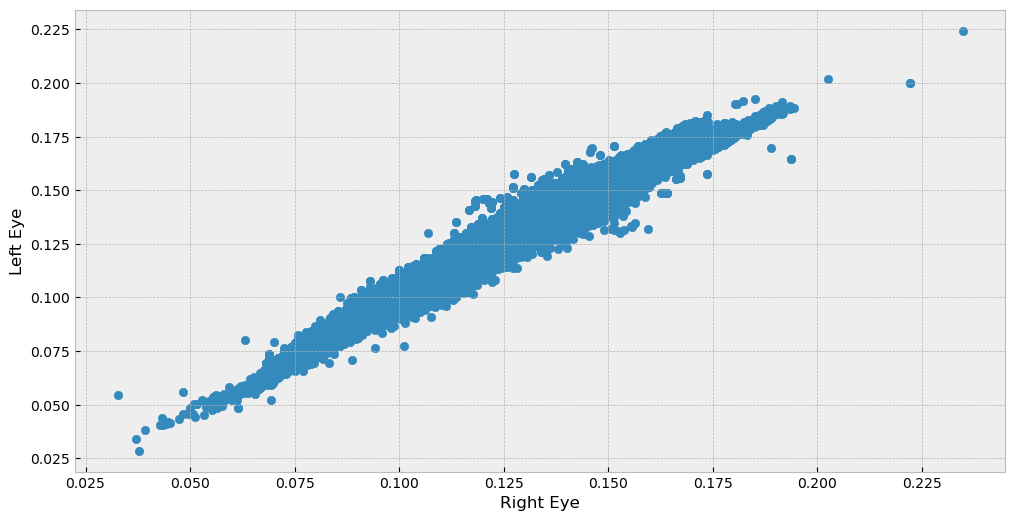

In [86]:
matplotlib.rcParams["figure.figsize"] = (12, 6)
plt.style.use("bmh")
plt.scatter(le, re)
plt.xlabel("Left Eye")
plt.ylabel("Right Eye")

Text(0, 0.5, 'Right Eye')

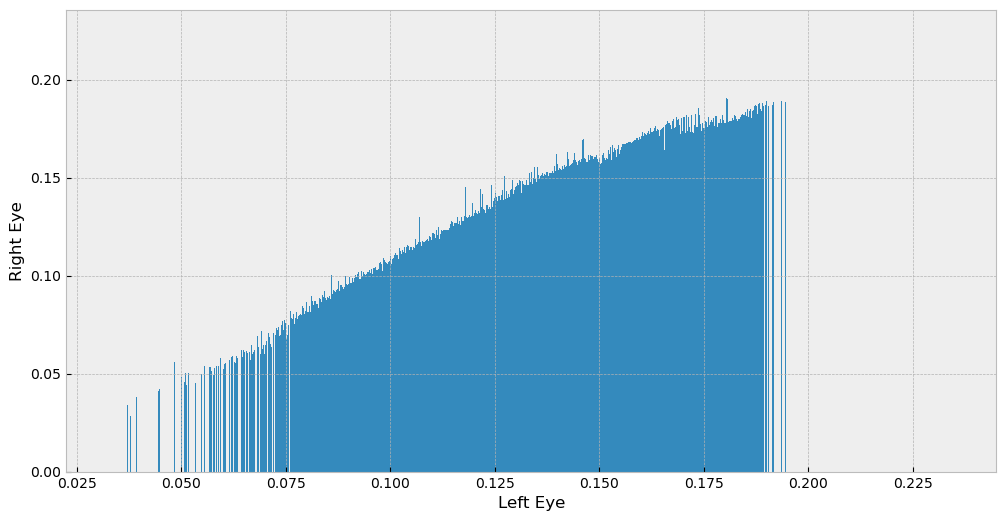

In [84]:
plt.bar(x = le, height = re, width = 0.0001)
plt.xlabel("Left Eye")
plt.ylabel("Right Eye")

Text(0, 0.5, 'Right Eye')

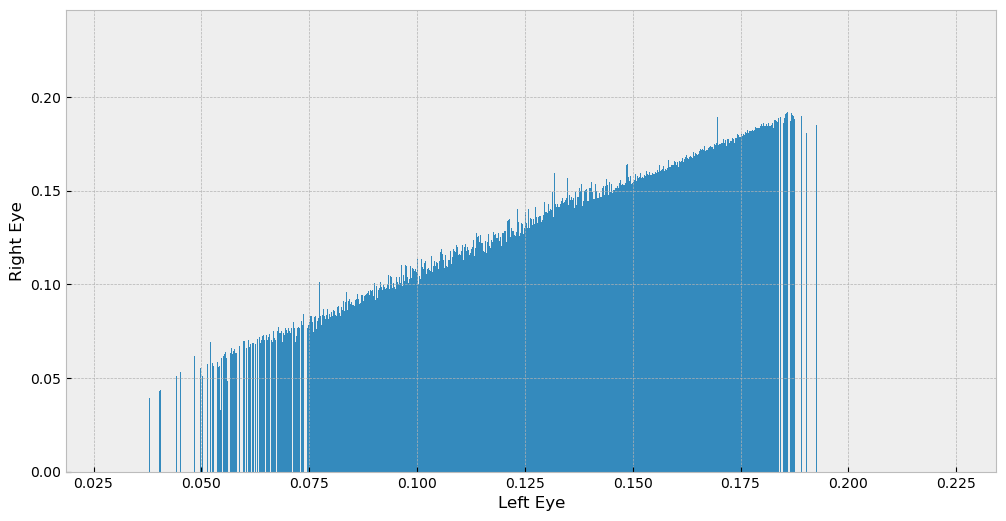

In [85]:
plt.bar(x = re, height = le, width = 0.0001)
plt.xlabel("Left Eye")
plt.ylabel("Right Eye")